In [5]:
from tiff_processing_utils import tile_tiff_pair, tile_tiff_triplet, rasterize_shapefile
from sentinel_hub_utils import call_s2l2a_api
from superres import SuperResolutionDataset
from torchgeo.models import resnet18, get_weight
import torch
import numpy as np
import psutil
import os
import gc
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

import os, sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))
from models import LatentSpaceExtractor

The processing pipeline assumes that the data in the Chunks folder is in the following format:
- Each chunk is in it's own folder and named 'Chunk x' or 'Chunk x x-x'
- The RGB tif should be named 'Chunkx.tif' or 'Chunkx_x-x.tif'
- label shape file and corresponding label files should be in a folder called 'labels' inside of the matching 'Chunk x' / 'Chunk x x-x' folder, the names of the files do not need to be formatted.

In [6]:
# unscaled_base_path is base path of all original Chunk folders
unscaled_base_path = ""
# scaled_base_path is base path of all scaled Chunk folders
scaled_base_path = "one_meter_naip"

TILE_SIZE = 224
STRIDE_SIZE = int(TILE_SIZE * 0.75) # stride used when tiling

combined_drone_file = os.path.join(scaled_base_path, f'{TILE_SIZE}dataset_drone.npy')
combined_label_file = os.path.join(scaled_base_path, f'{TILE_SIZE}dataset_label.npy')
combined_satellite_file = os.path.join(scaled_base_path, f'{TILE_SIZE}dataset_satellite.npy')

# RAM thresholds
TOTAL_RAM_MB = psutil.virtual_memory().total / (1024 ** 2)
SAFE_RAM_USAGE_MB = TOTAL_RAM_MB - 16 * 1024  # 16GB below total RAM
CHUNK_BUFFER_SIZE = 5  # Number of chunks to keep in memory at a time

In [ ]:
# Generate labels.tif for all orignal Chunk folders
for entry in os.listdir(unscaled_base_path):
    if 'Chunk' in entry:
        # create labels.tif
        chunk_path = os.path.join(unscaled_base_path, entry)
        rasterized_shape = rasterize_shapefile(chunk_path)

print('\nDone')


Done


In [84]:
# STOP
# Run resampling.py to scale original Chunk folders to 1m/pixel
# Scaled Chunk folders should have a Chunk{...}.tif, labels.tif, and satellite.tif file
# Then run all remaining cells to generate dataset from Scaled Chunks

# Generate satellite.tif for all scaled Chunk folders
# for entry in os.listdir(scaled_base_path):
#     if 'Chunk' in entry:
#         chunk_path = os.path.join(scaled_base_path, entry)
#         call_s2l2a_api(chunk_path) # create satellite.tif

print('\nDone')


Done


In [7]:
# Functions to monitor memory usage
def print_memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    print(f"Memory Usage: {mem_info.rss / (1024 ** 2):.2f} MB")

def get_memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss / (1024 ** 2)  # Return memory usage in MB

In [ ]:
"""
Convert all tif pairs into tiled datasets

NOTE: This will take a lot of time, memory, and storage space.
You should have at least 32GB of RAM and triple the chunk folder size of storage. If you don't have enough RAM,
you can run this script in smaller chunks by lowering the CHUNK_BUFFER_SIZE variable.
"""

# Function to append data to memory-mapped file
def append_to_memmap(file_path, data, dtype):
    if not os.path.exists(file_path):
        print(f"Creating new memmap file at {file_path}")
        new_memmap = np.lib.format.open_memmap(file_path, mode='w+', dtype=dtype, shape=data.shape)
        new_memmap[:] = data
    else:
        # Load the existing memmap
        memmap = np.load(file_path, mmap_mode='r+')
        new_shape = (memmap.shape[0] + data.shape[0],) + memmap.shape[1:]
        
        # Create a temporary memmap with the expanded size
        temp_file_path = file_path + '.tmp'
        new_memmap = np.lib.format.open_memmap(temp_file_path, mode='w+', dtype=dtype, shape=new_shape)
        
        # Copy old data into the temporary memmap
        new_memmap[:memmap.shape[0]] = memmap[:]
        
        # Append new data
        new_memmap[memmap.shape[0]:] = data
        
        # Flush and delete the old memmap
        del memmap
        new_memmap.flush()
        
        # Replace the original file with the temporary file
        os.replace(temp_file_path, file_path)

# Buffer for storing data before appending to memmap

drone_buffer = []
label_buffer = []
satellite_buffer = []

num_chunks = len([entry for entry in os.listdir(scaled_base_path) if 'Chunk' in entry])
print(f"Processing {num_chunks} chunk directories")

# Iterate over each chunk directory and process TIFF pairs
current_chunk = 0
for entry in os.listdir(scaled_base_path):
    if 'Chunk' in entry:
        current_chunk += 1
        print(f"\nChunk {current_chunk}/{num_chunks}")
        chunk_path = os.path.join(scaled_base_path, entry)
        
        # Generate tiled images and labels
        drone_images, labels, satellite_images = tile_tiff_triplet(chunk_path, image_size=TILE_SIZE, stride_size=STRIDE_SIZE)
        if drone_images.shape[0] == 0:
            print(f"No valid tiles found at {entry}")
            continue
        
        # Add to buffer
        drone_buffer.append(drone_images)
        label_buffer.append(labels)
        satellite_buffer.append(satellite_images)

        # Check memory usage and append to memmap if within threshold
        current_memory_usage = get_memory_usage()
        if current_memory_usage > SAFE_RAM_USAGE_MB or current_chunk % CHUNK_BUFFER_SIZE == 0:
            if current_memory_usage > SAFE_RAM_USAGE_MB:
                print(f"Memory usage {current_memory_usage:.2f} MB exceeds {SAFE_RAM_USAGE_MB} threshold. Appending to memmap.")
            else:
                print("Appending to memmap...")
            drone_to_append = np.concatenate(drone_buffer, axis=0)
            label_to_append = np.concatenate(label_buffer, axis=0)
            satellite_to_append = np.concatenate(satellite_buffer, axis=0)
            append_to_memmap(combined_drone_file, drone_to_append, np.uint8)
            append_to_memmap(combined_label_file, label_to_append, np.uint8)
            append_to_memmap(combined_satellite_file, satellite_to_append, np.uint8)
            
            # Clear buffer
            drone_buffer = []
            label_buffer = []
            satellite_buffer = []
            
            # Memory management
            print_memory_usage()
            del drone_to_append, label_to_append, satellite_to_append
            gc.collect()

# Final append if buffer is not empty
if drone_buffer:
    print("Appending remaining buffered data to memmap.")
    drone_buffer = np.concatenate(drone_buffer, axis=0)
    label_buffer = np.concatenate(label_buffer, axis=0)
    satellite_buffer = np.concatenate(satellite_buffer, axis=0)
    append_to_memmap(combined_drone_file, drone_buffer, np.uint8)
    append_to_memmap(combined_label_file, label_buffer, np.uint8)
    append_to_memmap(combined_satellite_file, satellite_buffer, np.uint8)
    
    # Clear buffer
    drone_buffer = []
    label_buffer = []
    satellite_buffer = []

print('\nDone tiling tif pairs')


'\ndrone_buffer = []\nlabel_buffer = []\nsatellite_buffer = []\n\nnum_chunks = len([entry for entry in os.listdir(scaled_base_path) if \'Chunk\' in entry])\nprint(f"Processing {num_chunks} chunk directories")\n\n# Iterate over each chunk directory and process TIFF pairs\ncurrent_chunk = 0\nfor entry in os.listdir(scaled_base_path):\n    if \'Chunk\' in entry:\n        current_chunk += 1\n        print(f"\nChunk {current_chunk}/{num_chunks}")\n        chunk_path = os.path.join(scaled_base_path, entry)\n\n        # Generate tiled images and labels\n        drone_images, labels, satellite_images = tile_tiff_triplet(chunk_path, image_size=TILE_SIZE, stride_size=STRIDE_SIZE)\n        if drone_images.shape[0] == 0:\n            print(f"No valid tiles found at {entry}")\n            continue\n\n        # Add to buffer\n        drone_buffer.append(drone_images)\n        label_buffer.append(labels)\n        satellite_buffer.append(satellite_images)\n\n        # Check memory usage and append to 

In [ ]:
"""
Convert image space numpy files into latent space numpy files
by encoding each image (drone or satellite) through the LatentSpaceEncoder class
"""

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    x = torch.ones(1, device=DEVICE)
    print("Using CUDA device.")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    x = torch.ones(1, device=DEVICE)
    print("Using Apple Metal Performance Shaders (MPS) device.")
else:
    DEVICE = torch.device("cpu")
    print("No GPU found. Defaulting to CPU.")

# Open input memmap files
drone_image_memmap = np.load(combined_drone_file, mmap_mode="r") # shape (B, C, H, W)
dB, dC, dH, dW = drone_image_memmap.shape
print(f"drone_image_memmap dtype: {drone_image_memmap.dtype}. min={drone_image_memmap.min()} max={drone_image_memmap.max()}")
satellite_image_memmap = np.load(combined_satellite_file, mmap_mode="r")
sB, sC, sH, sW = satellite_image_memmap.shape
print(f"satellite_image_memmap dtype: {satellite_image_memmap.dtype}. min={satellite_image_memmap.min()} max={satellite_image_memmap.max()}")
assert dB == sB, "drone image memmap and satellite image memmap have different batch lengths"
print(f"Drone image dataset has shape ({dB}, {dC}, {dH}, {dW}). Satellite image dataset has shape ({sB}, {sC}, {sH}, {sW})")

# Construct LatentSpaceExtractor
RGBResNet = resnet18(weights=get_weight("ResNet18_Weights.SENTINEL2_RGB_SECO"))
LSE = LatentSpaceExtractor(drone_resnet=RGBResNet, image_size=TILE_SIZE).to(DEVICE).eval()

# Get latent space shape
with torch.no_grad():
    dummy_drone = torch.zeros(1, dC, dH, dW, device=DEVICE)
    out_drone = LSE(dummy_drone)
    print(f"drone_latent dtype: {out_drone.dtype}. min={out_drone.min().item()} max={out_drone.max().item()}")

    dummy_sat = torch.zeros(1, sC+1, sH, sW, device=DEVICE)
    out_sat = LSE(dummy_sat)
_, ldC, ldH, ldW = out_drone.shape
_, lsC, lsH, lsW = out_sat.shape
print(f"Drone latent space shape will be (B, {ldC}, {ldH}, {ldW})")
print(f"Sat latent space shape will be (B, {lsC}, {lsH}, {lsW})")


# Construct output memmap files
combined_latent_drone_memmap = os.path.join(scaled_base_path, f'{TILE_SIZE}latent_dataset_drone.npy')
combined_latent_satellite_memmap = os.path.join(scaled_base_path, f'{TILE_SIZE}latent_dataset_satellite.npy')

# Buffer for storing data before appending to memmap
latent_drone_buffer = []
latent_satellite_buffer = []

with torch.no_grad():
  for batch_idx in range(dB):
      if (batch_idx % 1000 == 0):
          print(f"Processing batch_idx={batch_idx}")
      drone_tensor = torch.tensor(drone_image_memmap[batch_idx], dtype=torch.float32).to(DEVICE)
      sat_tensor = torch.tensor(satellite_image_memmap[batch_idx], dtype=torch.float32).to(DEVICE)
      zero_channel = torch.zeros(1, sH, sW, device=DEVICE)
      sat_tensor = torch.cat((sat_tensor[0:10], zero_channel, sat_tensor[10:]), dim=0)
      assert drone_tensor.shape[0] == 3, "drone_tensor does not have 3 channels"
      assert sat_tensor.shape[0] == 13, "sat_tensor does not have 13 channels"

      drone_latent = LSE(drone_tensor.unsqueeze(0)).cpu().numpy()
      sat_latent = LSE(sat_tensor.unsqueeze(0)).cpu().numpy()

      # Add to buffer
      latent_drone_buffer.append(drone_latent)
      latent_satellite_buffer.append(sat_latent)

      # Check memory usage and append to memmap if within threshold
      current_memory_usage = get_memory_usage()
      if current_memory_usage > SAFE_RAM_USAGE_MB:
          print(f"Memory usage {current_memory_usage:.2f} MB exceeds {SAFE_RAM_USAGE_MB} threshold. Appending to memmap.")
          drone_to_append = np.concatenate(latent_drone_buffer, axis=0)
          satellite_to_append = np.concatenate(latent_satellite_buffer, axis=0)
          append_to_memmap(combined_latent_drone_memmap, drone_to_append, dtype=np.float32)
          append_to_memmap(combined_latent_satellite_memmap, satellite_to_append, dtype=np.float32)
          
          # Clear buffer
          latent_drone_buffer = []
          latent_satellite_buffer = []
          
          # Memory management
          print_memory_usage()
          del drone_to_append, satellite_to_append
          gc.collect()

# Final append if buffer is not empty
if latent_drone_buffer:
    print("Appending remaining buffered data to memmap.")
    latent_drone_buffer = np.concatenate(latent_drone_buffer, axis=0)
    latent_satellite_buffer = np.concatenate(latent_satellite_buffer, axis=0)
    append_to_memmap(combined_latent_drone_memmap, latent_drone_buffer, dtype=np.float32)
    append_to_memmap(combined_latent_satellite_memmap, latent_satellite_buffer, dtype=np.float32)
    
    # Clear buffer
    latent_drone_buffer = []
    latent_satellite_buffer = []

print('\nDone mass encoding images into latent space')


Using Apple Metal Performance Shaders (MPS) device.
drone_image_memmap dtype: uint8. min=21 max=250
satellite_image_memmap dtype: uint8. min=0 max=255
Drone image dataset has shape (1980, 3, 224, 224). Satellite image dataset has shape (1980, 12, 224, 224)
drone_latent dtype: torch.float32. min=-0.0697188749909401 max=0.06985641270875931
Drone latent space shape will be (B, 256, 14, 14)
Sat latent space shape will be (B, 256, 14, 14)
Processing batch_idx=0
Processing batch_idx=1000
Appending remaining buffered data to memmap.
Creating new memmap file at one_meter_naip/224latent_dataset_drone.npy
Creating new memmap file at one_meter_naip/224latent_dataset_satellite.npy

Done mass encoding images into latent space


In [14]:
test_drone = np.load(combined_latent_drone_memmap, mmap_mode="r")
test_sat = np.load(combined_latent_satellite_memmap, mmap_mode="r")

print(f"drone_latent dtype: {test_drone.dtype}. min={test_drone.min()} max={test_drone.max()}")
print(f"sat_latent dtype: {test_sat.dtype}. min={test_sat.min()} max={test_sat.max()}")

ldB, ldC, ldH, ldW = test_drone.shape
lsB, lsC, lsH, lsW = test_sat.shape
print(f"Drone latent space shape will be ({ldB}, {ldC}, {ldH}, {ldW})")
print(f"Sat latent space shape will be ({lsB}, {lsC}, {lsH}, {lsW})")

drone_latent dtype: float32. min=-3.1015677452087402 max=3.3184895515441895
sat_latent dtype: float32. min=-0.640685498714447 max=0.7494438886642456
Drone latent space shape will be (1980, 256, 14, 14)
Sat latent space shape will be (1980, 256, 14, 14)


In [17]:
# Example dataset

drone_latent = np.load(combined_latent_drone_memmap, mmap_mode='r')
satellite_latent = np.load(combined_latent_satellite_memmap, mmap_mode='r')

dataset = SuperResolutionDataset(drone_latent, satellite_latent)
print(f"Dataset length: {len(dataset)}")
print(f"Dataset hr_latent shape: {dataset.hr_images[0].shape}")
print(f"Dataset lr_latent shape: {dataset.lr_images[0].shape}")

Dataset length: 1980
Dataset hr_latent shape: (256, 14, 14)
Dataset lr_latent shape: (256, 14, 14)


In [89]:
# If labels.tif files are no longer needed

# for entry in os.listdir(base_path):
#     if 'Chunk' in entry:
#         chunk_path = os.path.join(base_path, entry)
#         os.remove(os.path.join(chunk_path, 'labels.tif'))

In [90]:
def pixel_value_counts(arr):
    values, counts = np.unique(arr, return_counts=True)
    return {int(v): int(c) for v, c in zip(values, counts)} 

In [ ]:
# Visualize all 12 bands of satellite.tif
# Band information given here: https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l1c/
# band_names = ["B01 Coastal aerosol (60m)", "B02 Blue (10m)", "B03 Green (10m)", "B04 Red (10m)",
#               "B05 Red Edge 1 (20m)", "B06 Red Edge 2 (20m)", "B07 Red Edge 3 (20m)", "B08 NIR (10m)",
#               "B8A Narrow NIR (20m)", "B09 Water Vapor (60m)", "B11 SWIR 1 (20m)", "B12 SWIR 2 (20m)"
#               ]

# with rasterio.open('') as f:
#     bands = f.indexes
#     n_bands = len(bands)
#     n_cols = 4
#     n_rows = (n_bands + n_cols - 1) // n_cols
#     fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
#     axes = axes.flatten()

#     for idx, (ax, b) in enumerate(zip(axes, bands)):
#         arr = f.read(b)
#         show(arr, ax=ax, cmap="magma", title=f"{band_names[idx]}")
#         ax.axis('off')

#     fig.tight_layout()
#     plt.show()

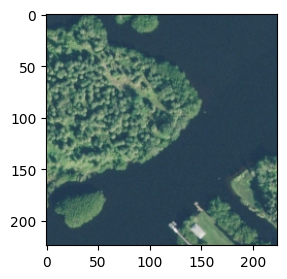

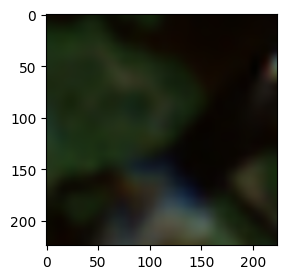

In [19]:
# Plot individual tile

drone_images = np.load(combined_drone_file, mmap_mode='r')
satellite_images = np.load(combined_satellite_file, mmap_mode='r')

idx = 1650
plt.figure(figsize=(3, 3))
plt.imshow(np.transpose(drone_images[idx], (1, 2, 0)))

'''
plt.figure(figsize=(3, 3))
plt.imshow(np.transpose(labels[idx], (1, 2, 0)), cmap='viridis')
print(pixel_value_counts(labels[idx]))
'''

plt.figure(figsize=(3, 3))
satellite_rgb = satellite_images[idx][[3, 2, 1], :, :]
plt.imshow(np.transpose(satellite_rgb, (1, 2, 0)))